# Modelo Final

## 0. Previos

Se cargan las bases y las librerías a utilizar.

In [44]:
# Librerías

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests
import pydotplus

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch


from scipy.stats import chi2_contingency, norm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.model_selection import GridSearchCV

from sympy import var, plot_implicit, Eq


#import generic_funcions as gf
#import adherence_functions as af
import warnings
warnings.filterwarnings('ignore')

ruta_archivos = ''

## 1. Variables Dataframe

In [45]:
base = pd.read_csv( ruta_archivos + 'base_adeherencia_features_3.csv', sep='|' )

In [46]:
print(base.shape)

base['adeherencia_12'] = (base['adeherencia_12']/base['cantidad']).apply(lambda x: 1 if x>=0.5 else 0)
#base['adeherencia_12'] = base['adeherencia_12'].apply(lambda x: 1 if x>=1 else x)

ids = ['id','year','month','adeherencia_12']
base.head()

(3717, 142)


,id,year,month,adeherencia_12,cantidad,key,far_rea_asma_sum_6,far_rea_total_sum_6,far_evo_aun_sum_6,far_cau_def_sum_6,...,hab_ejercicio_avg_12,inc_con_sum_6,inc_inc_sum_6,inc_con_sum_12,inc_inc_sum_12,imc_avg_6,imc_avg_12,imc_foto,adh_sum_6,adh_sum_12
0,500547,2016,7,0,1.0,1,NaN,NaN,NaN,NaN,...,NaN,0.0,3.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN
1,500547,2019,3,0,4.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500547,2019,10,0,5.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,NaN,0.0
3,500547,2019,12,0,4.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,0.0,0.0
4,500547,2020,1,0,3.0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.8,NaN,0.0,0.0


In [47]:
# Using variables vector of 'Mostrar' analysis.
vec2 = ['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12', 'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6', 'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12', 'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12', 'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6']
print(len(vec2))
vec2

15


['bio_benralizumab_avg_12',
 'med_num_doses_otra_avg_6',
 'anf_j_sum_12',
 'acd_uso_inhal_avg_12',
 'epo_4_sum_6',
 'bio_omalizumab_avg_6',
 'urg_j_total_sum_12',
 'cal_psi_avg_12',
 'med_num_dis_avg_12',
 'far_des_no_flag',
 'far_rea_total_sum_6',
 'far_cau_def_sum_12',
 'inc_inc_sum_12',
 'med_flag_j_avg_12',
 'adh_sum_6']

In [48]:
def preprocesar( base, ids, ruta_archivos ):
    
    # Variables 
    vec2 = ['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12', 'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6', 'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12', 'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12', 'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6']
    base_nueva = base[ids + vec2]
    
    # Imputación
    base_nueva.fillna(-1,inplace = True)
    
    # Carga Datos Básicos
    datosbasicos = pd.read_csv( ruta_archivos + 'DatosBasicos.csv', sep='|' )
    datosbasicos.drop_duplicates( inplace = True )
    datosbasicos.dropna( inplace = True )
    
    # Se dejan sólo ids únicos
    ids_count = datosbasicos.groupby('id').count()['year_n'].reset_index(name='cuenta')
    ids_unicos = ids_count[ids_count['cuenta']==1]
    datosbasicos = datosbasicos.merge(ids_unicos, how = 'inner')
    
    # Cruce datos básicos
    Agregada = base_nueva.merge(datosbasicos, on="id", how ='inner')
    
    
    # Procesamiento variables
    Agregada['edad'] = round((Agregada['year'] - Agregada['year_n']) + (Agregada['month'] - Agregada['month_n'])/12,0)
    Agregada.drop(columns=['Unnamed: 0', 'cuenta', 'fecha_n', 'year_n', 'month_n'], inplace= True)
    
    ### Variables categoricas
    categorias = ['genero', 'zona', 'ciudad']
    
    for var in categorias:
        Agregada[var] = Agregada[var].astype('category')
        Agregada[var]=Agregada[var].cat.codes
    
    # Escolaridad
    letras = ['ANALFABETA', 'EDAD PREESCOLAR', 'PRIMARIA', 'SECUNDARIA', 'TECNICO', 'TECNOLOGO', 'UNIVERSITARIO', 'POSGRADO']
    valor = [0,1,2,3,4,5,6,7]
    Agregada.replace(letras, valor,inplace = True)
    
    # Estado civil
    letras = ['SOLTERO (A)', 'UNIÓN LIBRE', 'CASADO (A)', 'SEPARADO (A)', 'VIUDO (A)']
    valor = [0,1,2,3,4]
    Agregada.replace(letras, valor,inplace = True)
    
    # Nivel socioeconomico
    letras = ['NIVEL 0 DEL SISBEN', 'NIVEL 1 DEL SISBEN', 'NIVEL 2 DEL SISBEN', 'A', 'B', 'C']
    valor = [0,1,2,3,4,5]
    Agregada.replace(letras, valor,inplace = True)
    
    # Ocupacion
    letras = ['SIN DEFINIR', 'ESTUDIANTE', 'DESEMPLEADO', 'AMA DE CASA', 'INDEPENDIENTE', 'EMPLEADO', 'JUBILADO', 'PENSIONADO']
    valor = [0,1,2,3,4,5,6,7]
    Agregada.replace(letras, valor,inplace = True)
    
    Agregada = Agregada.drop('departamento', axis=1 )
        
    return Agregada

In [49]:
df_t = preprocesar( base, ['id', 'year', 'month', 'adeherencia_12'], ruta_archivos )

In [50]:
df_t.head()

,id,year,month,adeherencia_12,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,...,adh_sum_6,genero,escolaridad,estadocivil,ciudad,estrato,zona,nivelsocioeconomico,ocupacion,edad
0,500547,2016,7,0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.0,1,3,2,26,3.0,1,3,5,54.0
1,500547,2019,3,0,-1.0,1021.800000,-1.0,-1.0,-1.0,-1.0,...,-1.0,1,3,2,26,3.0,1,3,5,57.0
2,500547,2019,10,0,-1.0,259.200000,-1.0,-1.0,-1.0,3.0,...,-1.0,1,3,2,26,3.0,1,3,5,57.0
3,500547,2019,12,0,-1.0,596.833333,-1.0,-1.0,-1.0,3.0,...,0.0,1,3,2,26,3.0,1,3,5,58.0
4,500547,2020,1,0,-1.0,732.000000,-1.0,-1.0,-1.0,3.0,...,0.0,1,3,2,26,3.0,1,3,5,58.0


## 2. Covariables

In [51]:
covariates=df_t.columns[4:]
covariates

Index(['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12',
       'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6',
       'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12',
       'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12',
       'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6', 'genero',
       'escolaridad', 'estadocivil', 'ciudad', 'estrato', 'zona',
       'nivelsocioeconomico', 'ocupacion', 'edad'],
      dtype='object')

### Arbol de guia

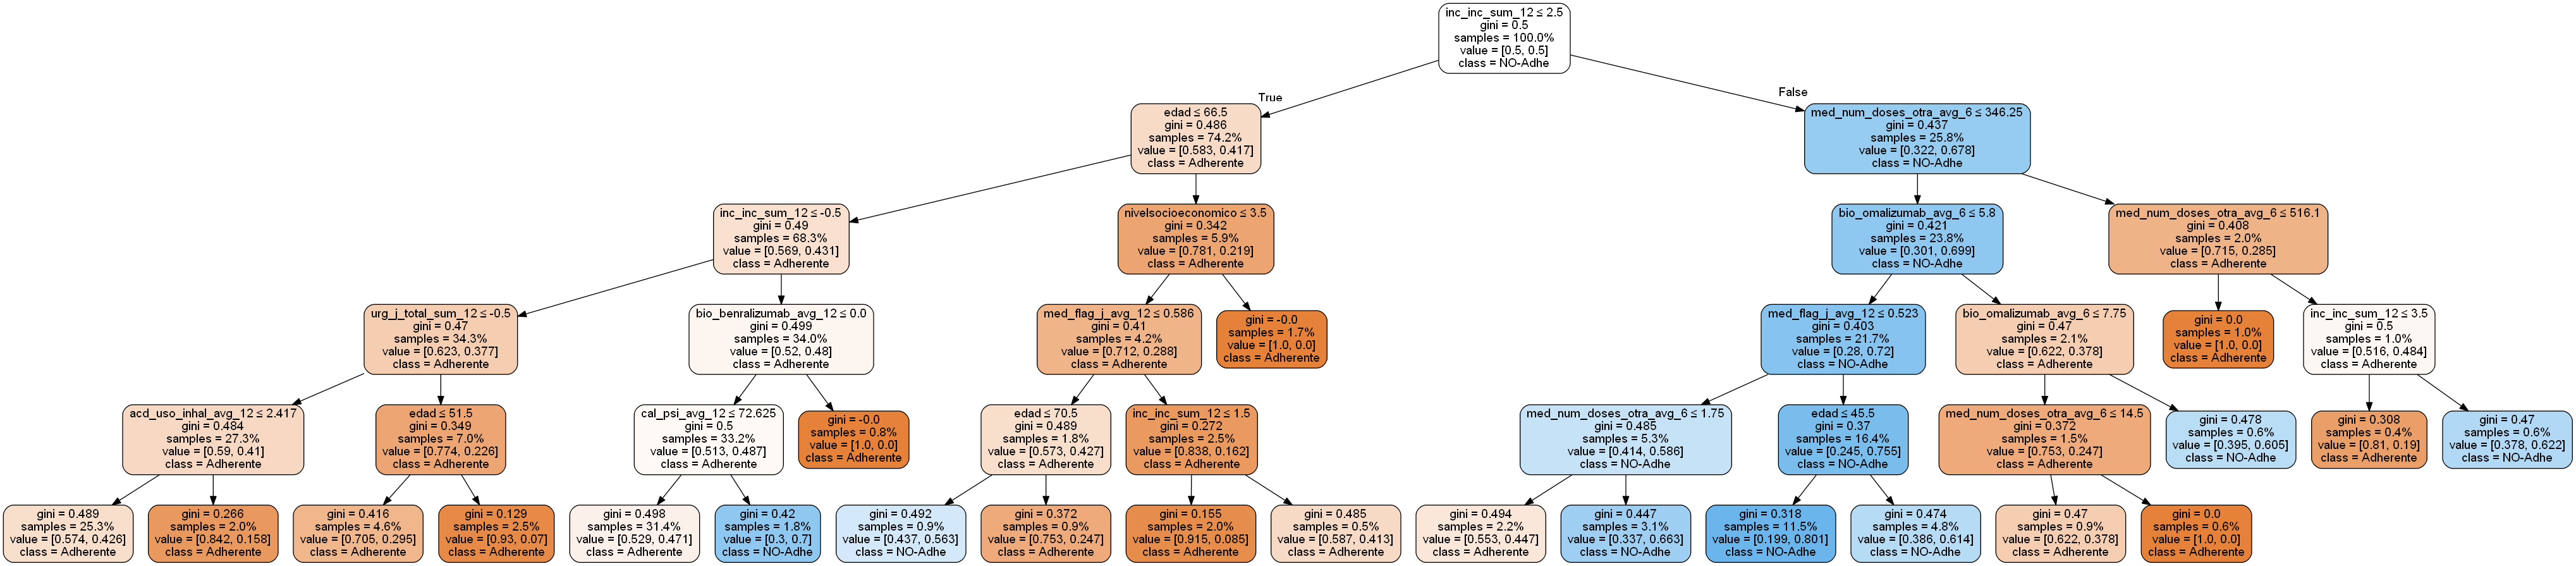

In [64]:
clf = DecisionTreeClassifier(max_depth =5, min_samples_leaf = 15,class_weight='balanced')

# Train Decision Tree Classifer
covariates=df_t.columns[4:]

clf = clf.fit(df_t[covariates], df_t['adeherencia_12'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates,
                class_names=['Adherente', 'NO-Adhe'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 3. Modelos

In [52]:
X = df_t[covariates]
y = df_t['adeherencia_12']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Logistic Regression

In [54]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
yl_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


[[544   8]
 [168  15]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       552
           1       0.65      0.08      0.15       183

    accuracy                           0.76       735
   macro avg       0.71      0.53      0.50       735
weighted avg       0.74      0.76      0.68       735



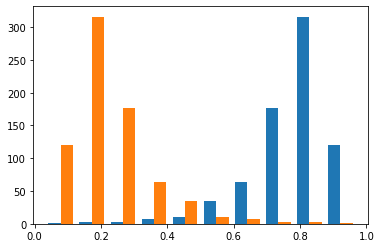

In [56]:
plt.hist(logreg.predict_proba(X_test))
print(confusion_matrix(y_test, yl_pred))
print(classification_report(y_test, yl_pred))

### Random forest

In [58]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': [10, 30, 50],
    'n_estimators': [5, 10, 20, 50]
}
# Create a based model
rf = RandomForestClassifier( class_weight='balanced' )
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [59]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 165 out of 180 | elapsed:    4.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.3s finished


{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 50}

[[446 106]
 [ 98  85]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       552
           1       0.45      0.46      0.45       183

    accuracy                           0.72       735
   macro avg       0.63      0.64      0.63       735
weighted avg       0.73      0.72      0.72       735



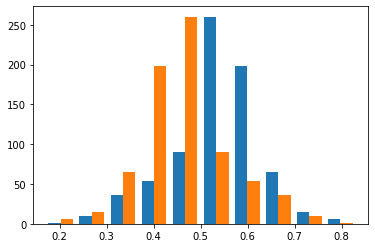

In [60]:
best_grid = grid_search.best_estimator_
y_opt = best_grid.predict(X_test)

plt.hist(best_grid.predict_proba(X_test))

print(confusion_matrix(y_test, y_opt))
print(classification_report(y_test, y_opt))

In [62]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, best_grid.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.reset_index(inplace = True)
importances = importances[importances['importance'] > 0].sort_values('importance', ascending = False).reset_index(drop = True)
importances.head()

,index,importance
0,inc_inc_sum_12,0.273206
1,edad,0.105891
2,med_num_doses_otra_avg_6,0.085640
3,cal_psi_avg_12,0.084023
4,med_num_dis_avg_12,0.064705


No handles with labels found to put in legend.


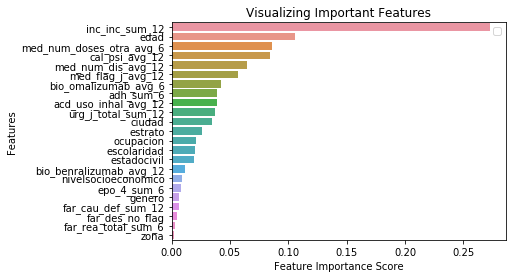

In [63]:
# Creating a bar plot
sns.barplot(x=importances['importance'], y=importances['index'])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## 4. Evaluación Base Completa

In [17]:
# Prediccion rf
pred = best_grid.predict_proba(df_t[covariates])
lstrf = [item[1] for item in pred]

# Prediccion lg
pred = logreg.predict_proba(df_t[covariates])
lstrl = [item[1] for item in pred]

df_t['y_total_rf'] = lstrf
df_t['y_total_rl'] = lstrl

# Redondeo

df_t_r = df_t[['adeherencia_12','y_total_rf','y_total_rl']]
df_t_r['y_total_rf_g'] = round(df_t_r['y_total_rf'],1)
df_t_r['y_total_rl_g'] = round(df_t_r['y_total_rl'],1)

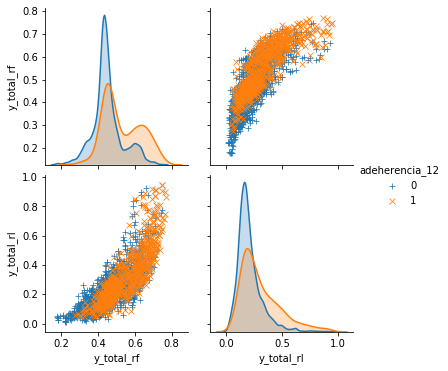

In [18]:
g = sns.pairplot(df_t_r[['adeherencia_12','y_total_rf','y_total_rl']], hue="adeherencia_12", markers=["+", "x"])

Text(0.5, 6.0, 'Logistic Regression')

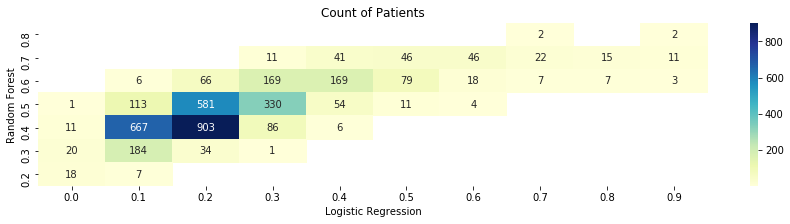

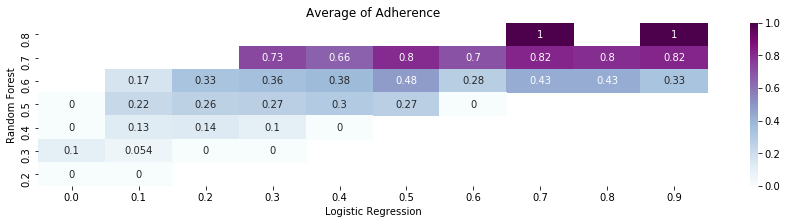

In [19]:
df_gwh = df_t_r.groupby(['y_total_rf_g','y_total_rl_g']).agg(avg=('adeherencia_12', 'mean'), cnt=('adeherencia_12', 'count')).reset_index()

df_gwh_p1 = df_gwh.pivot("y_total_rf_g", 'y_total_rl_g', "cnt")
df_gwh_p1.sort_index(level=0, ascending=False, inplace=True)

df_gwh_p2 = df_gwh.pivot("y_total_rf_g", 'y_total_rl_g', "avg")
df_gwh_p2.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_gwh_p1, cmap="YlGnBu", ax=ax, annot=True, fmt='g')
ax.set_title("Count of Patients")
plt.ylabel('Random Forest')
plt.xlabel('Logistic Regression')

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(df_gwh_p2, cmap="BuPu", ax=ax, annot=True) #RdYlGn
ax.set_title("Average of Adherence")
plt.ylabel('Random Forest')
plt.xlabel('Logistic Regression')

## 5. Evaluacion Base Mensual

In [20]:
base_calificar = pd.read_csv( ruta_archivos + 'base_adeherencia_calificar_1.csv', sep='|' )
base_calificar_a = preprocesar( base_calificar, ['id','year','month'], ruta_archivos )

In [21]:
base_calificar_a.head()

,id,year,month,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,urg_j_total_sum_12,...,adh_sum_6,genero,escolaridad,estadocivil,ciudad,estrato,zona,nivelsocioeconomico,ocupacion,edad
0,500547,2020,2,-1.0,840.833333,-1.0,-1.0,-1.0,-1.000000,0.0,...,0.0,1,3,2,27,3.0,1,3,5,58.0
1,500588,2020,2,-1.0,0.200000,-1.0,-1.0,-1.0,1.666667,-1.0,...,-1.0,1,2,0,5,2.0,1,4,1,15.0
2,502989,2020,2,-1.0,632.800000,-1.0,-1.0,-1.0,1.000000,-1.0,...,-1.0,1,6,0,27,3.0,1,3,0,30.0
3,506808,2020,2,-1.0,32.400000,-1.0,-1.0,-1.0,-1.000000,0.0,...,-1.0,1,1,0,4,1.0,1,3,1,11.0
4,512938,2020,2,-1.0,204.200000,-1.0,-1.0,-1.0,4.000000,0.0,...,1.0,0,3,0,27,3.0,1,3,5,22.0


In [22]:
base_calificar_a.shape

(860, 27)

In [23]:
# Prediccion rf
pred = best_grid.predict_proba(base_calificar_a[covariates])
lstrf = [item[1] for item in pred]

# Prediccion lg
pred = logreg.predict_proba(base_calificar_a[covariates])
lstrl = [item[1] for item in pred]

base_calificar_a['y_total_rf'] = lstrf
base_calificar_a['y_total_rl'] = lstrl

# Redondeo

base_calificar_a_r = base_calificar_a
base_calificar_a_r['y_total_rf_g'] = round(base_calificar_a_r['y_total_rf'],1)
base_calificar_a_r['y_total_rl_g'] = round(base_calificar_a_r['y_total_rl'],1)

Text(0.5, 6.0, 'Logistic Regression')

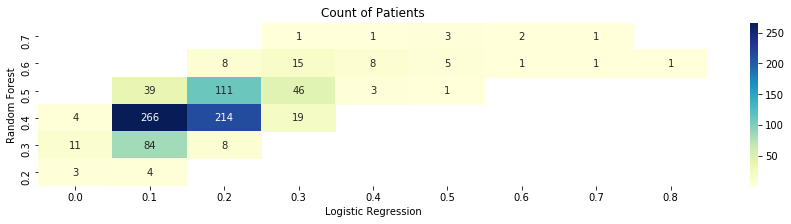

In [24]:
bc_gwh = base_calificar_a_r.groupby(['y_total_rf_g','y_total_rl_g']).agg(cnt=('id', 'count')).reset_index()

bc_gwh_p1 = bc_gwh.pivot("y_total_rf_g", 'y_total_rl_g', "cnt")
bc_gwh_p1.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 3))
sns.heatmap(bc_gwh_p1, cmap="YlGnBu", ax=ax, annot=True, fmt='g')
ax.set_title("Count of Patients")
plt.ylabel('Random Forest')
plt.xlabel('Logistic Regression')

In [25]:
def clasificacion( x ):
    y = '3 Alto'
    if (x['y_total_rf_g'] < 0.5 ):
        y = '1 Bajo'
    elif (x['y_total_rl_g'] < 0.4) or (x['y_total_rf_g'] < 0.7) :
        y = '2 Medio'
    return y

In [26]:
df_t_r_c = df_t_r
df_t_r_c['grupo'] = df_t_r_c.apply(clasificacion, axis = 1)

conteos = df_t_r_c.groupby('grupo').count()['y_total_rf'].reset_index(name='cta').sort_values('grupo')
conteos['porcentaje'] = round( conteos['cta']/df_t_r_c.shape[0], 2 )
conteos

,grupo,cta,porcentaje
0,1 Bajo,1937,0.52
1,2 Medio,1629,0.43
2,3 Alto,185,0.05


In [27]:
bc_c = base_calificar_a_r
bc_c['grupo'] = bc_c.apply(clasificacion, axis = 1)

conteos = bc_c.groupby('grupo').count()['y_total_rf'].reset_index(name='cta').sort_values('grupo')
conteos['porcentaje'] = round( conteos['cta']/bc_c.shape[0], 2 )
conteos

,grupo,cta,porcentaje
0,1 Bajo,613,0.71
1,2 Medio,240,0.28
2,3 Alto,7,0.01


### Explain the risk factors

In [34]:
df_t['y_total_rf_g'] = round(df_t['y_total_rf'],1)
df_t['y_total_rl_g'] = round(df_t['y_total_rl'],1)
df_t['grupo'] = df_t.apply(clasificacion, axis = 1)
df_t

,id,year,month,adeherencia_12,bio_benralizumab_avg_12,med_num_doses_otra_avg_6,anf_j_sum_12,acd_uso_inhal_avg_12,epo_4_sum_6,bio_omalizumab_avg_6,...,estrato,zona,nivelsocioeconomico,ocupacion,edad,y_total_rf,y_total_rl,y_total_rf_g,y_total_rl_g,grupo
0,500547,2016,7,0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,3.0,1,3,5,54.0,0.538249,0.267969,0.5,0.3,2 Medio
1,500547,2019,3,0,-1.0,1021.800000,-1.0,-1.0,-1.0,-1.0,...,3.0,1,3,5,57.0,0.254762,0.026208,0.3,0.0,1 Bajo
2,500547,2019,10,0,-1.0,259.200000,-1.0,-1.0,-1.0,3.0,...,3.0,1,3,5,57.0,0.362366,0.068212,0.4,0.1,1 Bajo
3,500547,2019,12,0,-1.0,596.833333,-1.0,-1.0,-1.0,3.0,...,3.0,1,3,5,58.0,0.263947,0.048023,0.3,0.0,1 Bajo
4,500547,2020,1,0,-1.0,732.000000,-1.0,-1.0,-1.0,3.0,...,3.0,1,3,5,58.0,0.255928,0.038508,0.3,0.0,1 Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,1999536,2018,8,0,-1.0,2.000000,-1.0,-1.0,-1.0,1.0,...,4.0,1,4,5,27.0,0.444112,0.128140,0.4,0.1,1 Bajo
3764,1999536,2020,2,0,-1.0,33.400000,-1.0,-1.0,-1.0,1.0,...,4.0,1,4,5,28.0,0.461824,0.167484,0.5,0.2,2 Medio
3765,1999629,2018,4,0,-1.0,3.666667,-1.0,-1.0,-1.0,2.0,...,3.0,1,3,1,19.0,0.465902,0.220065,0.5,0.2,2 Medio
3766,1999629,2018,5,0,-1.0,3.000000,-1.0,-1.0,-1.0,2.0,...,3.0,1,3,1,20.0,0.465902,0.246757,0.5,0.2,2 Medio


In [37]:
covariates

Index(['bio_benralizumab_avg_12', 'med_num_doses_otra_avg_6', 'anf_j_sum_12',
       'acd_uso_inhal_avg_12', 'epo_4_sum_6', 'bio_omalizumab_avg_6',
       'urg_j_total_sum_12', 'cal_psi_avg_12', 'med_num_dis_avg_12',
       'far_des_no_flag', 'far_rea_total_sum_6', 'far_cau_def_sum_12',
       'inc_inc_sum_12', 'med_flag_j_avg_12', 'adh_sum_6', 'genero',
       'escolaridad', 'estadocivil', 'ciudad', 'estrato', 'zona',
       'nivelsocioeconomico', 'ocupacion', 'edad'],
      dtype='object')

In [39]:
bajo = df_t[df_t['grupo'] == '1 Bajo']
medio = df_t[df_t['grupo'] == '2 Medio']
alto = df_t[df_t['grupo'] == '3 Alto']